![Alt text](./images/Transformer.jpg)

1. By the picture, we see that the input image (a) is “cut” into sub-images equally sized.

2. Each such sub-image goes through a linear embedding. From then on, each sub-image is just a one-dimensional vector.

3. A positional embedding is then added to these vectors (tokens). The positional embedding allows the network to know where each sub-image is positioned originally in the image.

4. These tokens are then passed, together with a special classification token, to the transformer encoders blocks

5. transformer encoders blocks :
    1. A Layer Normalization (LN), followed by a Multi-head Self Attention (MSA) and a residual connection. Then a second LN, a Multi-Layer Perceptron (MLP), and again a residual connection. These blocks are connected back-to-back.

6. Finally, a classification MLP block is used for the final classification only on the special classification token, which by the end of this process has global information about the picture.

# In Vision Transofrmer we're only using the Encoder Block
--------------------------------------------------------------
### So looking at the steps we would have the following

#### 1. Transformer was originally made for sequential data .. how would we do this for images ?, we simply divide our image into patches and turn each patch into a single image and then turn that single image into a single Vector -> for ex : image (28*28 pixels), lets split to 7*7 patches -> 28 / 7 -> we get 4*4 patches = 16 patches .. then we turn every patch of these 16 patches into a single vector that is (7*7 = 49 units long)

#### 2. now we got 4*4 -> 16 vectors each is 49 long 

#### 3. now assuming we have our images as (B,C,W,H) -> we get now (B,7*7,4*4) -> (B,49,16)


![Alt text](./images/img_patches.jpg)

# What are Embeddings ?

if we have wheat -> we can't use it direclty unless we transform it to flour to make bread - dodo bread .. brngaliese

and this is the essence of embedding, something like patches of images, we can't deal with it directly
we need embeddings which is a different representation of the patches, the only thing is that it's ``` Learnable ```  

# steps :
1. making patches
2. turning each patch into 768 long representation .. so 14*14 patches is 196
3. 196 image patches are turned into 768 long representation

In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from ensure import ensure_annotations


np.random.seed(0)
torch.manual_seed(0)

# Input shape = (H x W x C)
# output shape = (N x (P**2 x C))
N = number of patches
D = latent vector size , embeddings size

In [2]:
height = 224
width = 224
c = 3
patch_size = 16


number_of_patches = int(( height * width ) / patch_size**2)

print(number_of_patches)



196


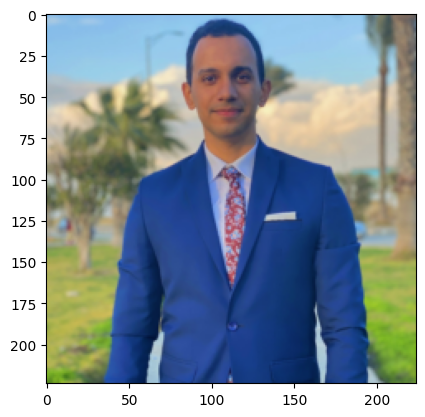

Tensor shape: torch.Size([3, 224, 224])


In [3]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image
image_path = './images/img.jpg'

# Open the image using PIL
img = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the desired size
    transforms.ToTensor()            # Convert to PyTorch tensor
])

# Apply the transformation
img_tensor = transform(img)

img_perm = img_tensor.permute(1, 2, 0)

# Display the resized image
plt.imshow(img_perm)  # permute to change the order of dimensions
plt.show()

# Print the shape of the resulting tensor
print("Tensor shape:", img_tensor.shape)


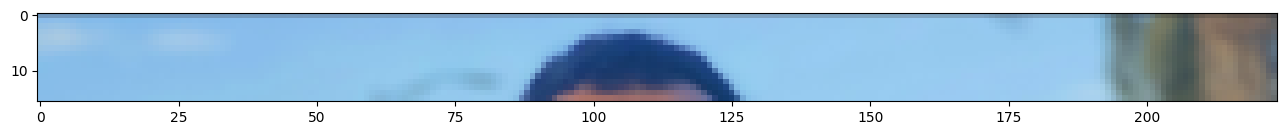

In [4]:
patch_size = 16

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_perm[:patch_size,:,:])

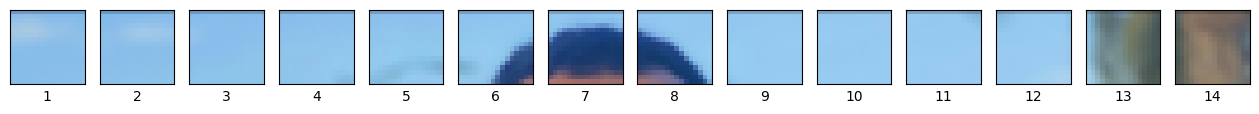

In [5]:
fig , axs = plt.subplots(
    nrows=1,
    ncols = int(224 / patch_size), # 224 is img_size
    sharex= True,
    sharey= True,
    figsize=(patch_size, patch_size)
)

for i , patch in enumerate(range(0, 224,patch_size)):
    axs[i].imshow(img_perm[:patch_size,patch:patch + patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])    

In [6]:
conv2d = nn.Conv2d(in_channels= 3,out_channels= 768,kernel_size=patch_size,stride=patch_size,padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [7]:
img_out_of_conv = conv2d(img_tensor.unsqueeze(dim=0))
img_out_of_conv.shape

torch.Size([1, 768, 14, 14])

## Lets visualize some of these 14*14 patches

In [8]:
import random 
random_idxs = random.sample(range(0,767),k=5)
random_idxs

[222, 416, 36, 203, 176]

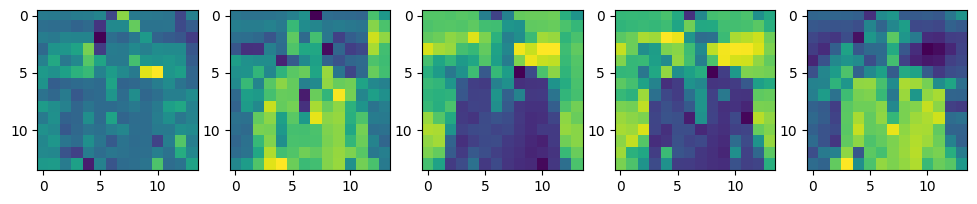

In [9]:
fig ,axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12,12))
for i , idx in enumerate(random_idxs):
    im = img_out_of_conv[:,idx,:,:]
    """
    We need to remove extra batch dimension and also detach the tensor from gradient tracking 
    otherwise we will get an error
    """
    axs[i].imshow(im.squeeze().detach().numpy()) 

### Now you see these feature maps .. we need to Flatten these using `torch.nn.Flatten`

* Flatten function has a start dim and end dim parameters which help us here because we want to flatten only 2,3 indices -> (1,768,14,14)

In [10]:
from torch import nn
Flatten_layer = nn.Flatten(start_dim=2,end_dim=3)
img_flattened = Flatten_layer(img_out_of_conv)
img_flattened.shape

torch.Size([1, 768, 196])

In [11]:
# rearrange the shape
img = img_flattened.permute(0,2,1)
img.shape

torch.Size([1, 196, 768])

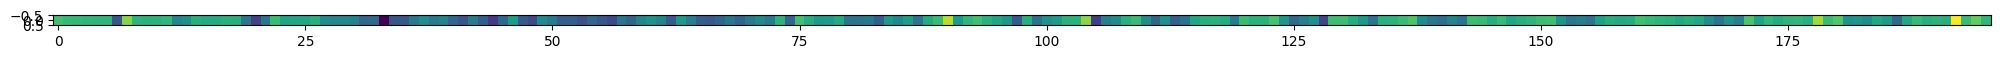

In [12]:
plt.figure(figsize=(25,25))
plt.imshow(img[:,:,0].detach().numpy())

# Modularization

In [13]:
class patchembeddings(nn.Module):
    def __init__(self,
                in_channels:int = 3,
                patch_size:int =16,
                embdeddings_dim:int = 768):
        
        super(patchembeddings,self).__init__()
        """lets make a block called the patcher which is responsible for breaking
        the image into patches of patch_size """

        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embdeddings_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0
                                )
        
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)
    
    @ensure_annotations
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        # lets check for some condition
        image_res = x.shape[-1] # (1,224,224) -> 224
        assert image_res % self.patch_size == 0 , f"image size must be divisible by patch size, image_shape {x.shape}, patch size : {self.patch_size} "
        # patching
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # permute to return the right shape (1,196,768)
        return x_flattened.permute(0,2,1)

In [14]:
patchify = patchembeddings()
print(img_tensor.shape)
patchified_image = patchify(img_tensor.unsqueeze(0))
patchified_image.shape # This what we want

torch.Size([3, 224, 224])


torch.Size([1, 196, 768])

## Let's check if patch embedding wont work if image_res % patch_size == 0

In [15]:
patchify = patchembeddings()
good_tensor = patchify(torch.randn(size=(1,3,224,224)))
bad_tensor = patchify(torch.randn(size=(1,3,250,250)))
# bad_tensor

AssertionError: image size must be divisible by patch size, image_shape torch.Size([1, 3, 250, 250]), patch size : 16 

## Class token : we prepend which means put at the beginning, that extra learnable embedding

In [18]:
"""now we need to change that shape of 196 to be 197 
    by adding that extra learnable embedding `class token`

    The question is how to do that ?
    We need to concat that extra learnable embedding to the original embedding
    (1,196,768) -> (1,197,768)
    So what comes out of the class we made earlier is in the shape of (1,196,768)
    so we simply use the concat on dim = 1
    
    
    """
patchified_image.shape

torch.Size([1, 196, 768])

In [19]:
class_token = nn.Parameter(torch.ones(1,1,768),requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [20]:
# now we have what we want
class_token.shape , patchified_image.shape

(torch.Size([1, 1, 768]), torch.Size([1, 196, 768]))

In [21]:
image_With_class_token = torch.concat(tensors=(class_token,patchified_image),dim=1)
image_With_class_token.shape

torch.Size([1, 197, 768])

In [22]:
# Let's take a look, notice all the ones at the begining
image_With_class_token

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.3344, -0.4649,  0.0662,  ..., -0.7153, -0.8887,  0.5118],
         [ 0.3293, -0.4685,  0.0525,  ..., -0.7322, -0.8827,  0.5189],
         ...,
         [ 0.1350, -0.2253,  0.0049,  ..., -0.3090, -0.3477,  0.2572],
         [ 0.1472, -0.1403,  0.0593,  ..., -0.3653, -0.4723,  0.3449],
         [ 0.2459, -0.2267,  0.2005,  ..., -0.4522, -0.5400,  0.2879]]],
       grad_fn=<CatBackward0>)

### now lets do it the right way and add position embeddings 

In [23]:
number_of_patches = int((height*width)/patch_size**2) 
print(f"the no. of patches is : {number_of_patches}")
embdedding_dim = image_With_class_token.shape[-1]
# create the position embeddings
position_embeddings = nn.Parameter(torch.ones(1,number_of_patches+1,embdedding_dim),requires_grad=True)
position_embeddings.shape #now we matched the image_with_class_token 

the no. of patches is : 196


torch.Size([1, 197, 768])

In [24]:
""" next we will add the position embeddings and image_with_class_token , so first of all we
    need to make them in the same shape otherwise we will have an error like the one in this cell.
"""
# Define two tensors with different shapes
A = torch.tensor([[1, 2, 3,4]])
B = torch.tensor([[4, 5, 6]])

C = A + B

# Print the result
print("Resultant Tensor (C):", C)

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 1

In [25]:
# lets add them now
patch_and_position_emb = image_With_class_token + position_embeddings
patch_and_position_emb.shape , patch_and_position_emb

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.3344, 0.5351, 1.0662,  ..., 0.2847, 0.1113, 1.5118],
          [1.3293, 0.5315, 1.0525,  ..., 0.2678, 0.1173, 1.5189],
          ...,
          [1.1350, 0.7747, 1.0049,  ..., 0.6910, 0.6523, 1.2572],
          [1.1472, 0.8597, 1.0593,  ..., 0.6347, 0.5277, 1.3449],
          [1.2459, 0.7733, 1.2005,  ..., 0.5478, 0.4600, 1.2879]]],
        grad_fn=<AddBackward0>))

# Next , Multi-Head Attention

### Additional sources : inside deep learning p.227 Normalization Layers

In [26]:
import torch
from torch import nn
class MultiHeadAttention(nn.Module):
    """
    creates a multi-head self-attention block 
    """
    def __init__(self,
                embedding_dim:int=768, # hidden size D for embeddings dim
                num_heads:int=12, # heads from table 1
                attn_dropout:int=0):
        super(MultiHeadAttention, self).__init__()
        # Create the Layer Norm
        self.layer_norm = nn.LayerNorm(normalized_shape=embdedding_dim)

        # Create MultiHead self attention
        self.multi_head_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True ) # batch first means the input is in shape of (batch,seq,feature)  -> (batch , number of patches , embedding dimension) 
    @ensure_annotations
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        attn_output , _ = self.multi_head_attn(query=x,
                                            key=x,
                                            value=x,
                                            need_weights=False)
        return attn_output

In [27]:
multi_head_self_attention_block = MultiHeadAttention(embedding_dim=768,num_heads=12,attn_dropout=0)

patched_image_through_msa_block = multi_head_self_attention_block(patch_and_position_emb)
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])

In [28]:
patched_image_through_msa_block

tensor([[[ 0.4573,  0.5404, -0.1886,  ..., -0.0085, -0.1737, -0.3860],
         [ 0.4513,  0.5336, -0.1791,  ...,  0.0173, -0.1878, -0.3864],
         [ 0.4512,  0.5339, -0.1794,  ...,  0.0166, -0.1884, -0.3863],
         ...,
         [ 0.4565,  0.5346, -0.1836,  ...,  0.0158, -0.1860, -0.3835],
         [ 0.4494,  0.5404, -0.1799,  ...,  0.0025, -0.1827, -0.3850],
         [ 0.4474,  0.5378, -0.1778,  ...,  0.0142, -0.1840, -0.3899]]],
       grad_fn=<TransposeBackward0>)

### Multi Layer Perceptron Block

According to the paper, the MLP consists of two linear layers with a GELU non-linearuty and followed by dropout

hyperparameters -> table 3

In [29]:
class MLPblock(nn.Module):
    def __init__(self,embedding_dim:int=768,
                mlp_size:int=3072,
                dropout:float=0.1):
        super(MLPblock, self).__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                    out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                    out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    @ensure_annotations
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x


In [30]:
class TranformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,# hidden size D from table 1 , 768 for ViT-Base
                num_head:int=12, # from table 1
                mlp_size:int=3072 ,# from table 1
                mlp_dropout:int=0.1,# from table 3
                attn_dropout:int=0):
        super(TranformerEncoderBlock,self).__init__()

        # eqn 2
        self.msa_block = MultiHeadAttention(embedding_dim=embedding_dim,
                                            num_heads=num_head,
                                            attn_dropout=attn_dropout
                                            ) 
        # eqn 3
        self.mlp_block = MLPblock(embedding_dim=embedding_dim,
                                mlp_size=mlp_size,
                                dropout=mlp_dropout)
    
    @ensure_annotations
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        x = self.msa_block(x) + x # skip connection
        x = self.mlp_block(x) + x # skip connection
        return x

In [31]:
from torchinfo import summary
"""Lets give it a try and see if it works"""
summary(model=TranformerEncoderBlock(),input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TranformerEncoderBlock (TranformerEncoderBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadAttention (msa_block)                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multi_head_attn)        --                   [1, 197, 768]        2,362,368            True
├─MLPblock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Making the ViT 

In [32]:
class ViT(nn.Module):
    def __init__(self,
                img_size:int=224, # table 3 from the paper
                in_channels:int = 3,
                patch_size:int=16,
                num_transformer_layer:int=12, # table 1 for layer ViT base
                embedding_dim:int =768, # hidden size D
                mlp_size:int=3072,
                num_heads:int = 12, # table 1
                attn_dropout:int=0,
                mlp_dropout:int=0.1,
                embedding_dropout:int=0.1, # dropout for patch and position embeddings
                num_classes:int=1000
                ):
        super(ViT,self).__init__()
        
        # make sure we have the compatible image size and patch size  
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image : {img_size} patch size {patch_size}"

        # calculate the number of patches (height*width) / patch_size**2
        self.num_patches = (img_size*img_size)// patch_size**2

        # create Learnable class embeddings
        """we have the shape of (1,196,768) we need to prepend class token -> (1,197,768)"""
        self.class_embeddings = nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)

        # create Learnable position embeddings
        self.position_embeddings = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),requires_grad=True)

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embeddings 
        self.patch_embeddings = patchembeddings(in_channels=in_channels,
                                                embdeddings_dim=embedding_dim,
                                                patch_size=patch_size)
        
        """now to make the multi head attention we use the module layers list property in PyTorch"""
        self.transformer_encoder = nn.Sequential(*[TranformerEncoderBlock(embedding_dim=embedding_dim,
                                                                        num_head=num_heads,
                                                                        mlp_size=mlp_size,
                                                                        mlp_dropout=mlp_dropout)
                                                                        for _ in range(num_transformer_layer)])
        
        # Create Classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,out_features=num_classes)
        ) 

    @ensure_annotations
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # Get th patch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it to match the batch size eqn 1
        class_token = self.class_embeddings.expand(batch_size,-1,-1) # -1 means to infer the dimensions

        # 14. Create patch embedding (equation 1)
        x = self.patch_embeddings(x)

        # concat class token and patch embeddings eqn 1
        x = torch.cat(tensors=(class_token,x),dim=1)

        # add position embeddings to class token and patch embeddings
        x = self.position_embeddings + x
        
        # Apply dropout to patch embeddings
        x = self.embedding_dropout(x)

        # pass position and patch embeddings to transformer encoder (eqn 2,3)
        x = self.transformer_encoder(x)

        # put the 0th index logit through the classifier
        x = self.classifier(x[:,0])

        return x        

In [33]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embeddings): patchembeddings(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TranformerEncoderBlock(
      (msa_block): MultiHeadAttention(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multi_head_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPblock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): 

In [34]:
vit = ViT(num_classes=1000)
vit
# summary(model=vit,input_size=(1,3,224,224))
random_tensor_img = torch.randn(1,3,224,224)
vit(random_tensor_img)

tensor([[ 4.4192e-01, -9.9239e-01, -3.3827e-01, -1.8298e-01, -2.5719e-01,
          6.7669e-01,  5.9838e-01, -2.0267e-01,  4.4783e-01, -1.0838e-01,
         -2.6036e-01, -3.6210e-01, -1.2742e+00, -4.5922e-01,  4.2692e-01,
         -1.1512e-01, -1.1013e-01, -2.6074e-01,  4.6242e-01, -6.1234e-03,
         -2.3887e-01,  8.3819e-01,  3.4107e-01, -4.4119e-01,  1.5888e-01,
          2.6032e-01, -4.0310e-02,  5.9294e-02, -1.9853e-01, -3.8799e-01,
          5.4501e-01, -1.6880e-01, -8.5430e-01,  5.3826e-01, -6.1482e-01,
         -1.6598e-01,  6.7775e-02, -7.5849e-01,  6.8369e-01, -3.1619e-01,
          6.9142e-01, -1.3938e+00,  3.2076e-01,  4.6665e-01, -4.1169e-01,
          6.2706e-01, -1.8097e-01,  1.3179e-01, -3.9858e-01, -4.4017e-01,
          6.9314e-01, -6.6085e-02,  6.1844e-02, -2.7661e-01, -2.1015e-01,
         -1.1580e-01, -1.6062e-01, -2.2045e-01,  7.2700e-01, -3.8893e-01,
         -1.1868e-01,  7.6848e-01,  8.2242e-02,  6.0830e-01,  2.2789e-01,
          5.3264e-01,  4.3930e-01, -6.

In [35]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 1000]           152,064              True
├─patchembeddings (patch_embeddings)                         [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TranformerEncoderBlock (0)                            [32, 197, 768]       [32, 197, 768]

# Training Time

In [36]:
vit = ViT(num_classes=10,in_channels=1)

In [ ]:
from train import train
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

train_set = MNIST(root='./MNIST',train=True,download=True,transform=transform)
test_set = MNIST(root='./MNIST',train=False,download=True,transform=transform)

train_loader = DataLoader(train_set,batch_size=3,shuffle=True)
test_loader = DataLoader(test_set,batch_size=3,shuffle=False)

# Set the seeds
torch.manual_seed(42)

# Train the model and save the training results to a dictionary
results = train(model=vit,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1,
                       device='cuda')